<a href="https://colab.research.google.com/github/MasaAsami/shap_no_use_for_causal/blob/main/notebooks/shaply_no_causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [ ]:
import numpy as np
import pandas as pd
from itertools import permutations, product
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import networkx as nx
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns

# Seaborn のスタイルとコンテキストを設定
sns.set_style("ticks")          # クリーンなスタイル
sns.set_context("paper")        # 論文用のコンテキスト設定

# ASVは無理


- そもそもASVはいろんなところが間違ってる
- 学習済みのモデルはもうそこでパラメータが固定してるんだから、ポストホックな対応でcausalな解釈ができるわけないじゃん
- あと、Shaply Axiom 1: 効率性についても違反してる
- そもそも、SVの定義変えているんだから自明だろ、そこは（なぜ気づかなかった

In [ ]:
class AsymmetricShapleyValues:
    def __init__(self, model, predict_function, causal_hierarchy, random_seed=None, n_jobs=1, n_samples=None, parallel=True):
        """
        Initialize the Asymmetric Shapley Values object.

        Parameters:
        - model: A trained prediction model.
        - predict_function: A wrapper function that takes the model and a DataFrame of instances.
        - causal_hierarchy: List of lists defining causal relationships. Each list contains features treated as unordered within the list but ordered relative to other lists.
        - random_seed: Optional integer for random seed to ensure reproducibility.
        - n_jobs: Number of parallel jobs for computation.
        - n_samples: Optional integer for sampling feature_orderings. If None, all permutations are used.
        - parallel: Boolean to enable or disable parallel computation.
        """
        self.model = model
        self.predict_function = predict_function
        self.random_seed = random_seed
        self.n_jobs = n_jobs
        self.n_samples = n_samples
        self.causal_hierarchy = causal_hierarchy
        self.parallel = parallel

        if random_seed is not None:
            np.random.seed(random_seed)

    def _generate_feature_orderings(self, features):
        """
        Generate all valid feature_orderings based on causal hierarchy.

        Parameters:
        - features: List of all features.

        Returns:
        - List of valid feature_orderings.
        """
        hierarchy_feature_orderings = []

        # Generate all permutations for each level in the hierarchy
        for group in self.causal_hierarchy:
            group_permutations = list(permutations(group))
            hierarchy_feature_orderings.append(group_permutations)

        # Combine permutations respecting hierarchy
        all_feature_orderings = []
        for combination in product(*hierarchy_feature_orderings):
            all_feature_orderings.append([feature for group in combination for feature in group])

        if self.n_samples is not None:
            np.random.seed(self.random_seed)
            indices = np.random.choice(len(all_feature_orderings), size=self.n_samples, replace=False)
            return [all_feature_orderings[i] for i in indices]

        return all_feature_orderings

    def _mask_features(self, instances_to_explain, features_to_keep, reference_data):
        """
        Mask features in bulk for all instances.

        Parameters:
        - instances_to_explain: DataFrame of instances to explain.
        - features_to_keep: List of features to retain without masking.
        - reference_data: DataFrame used for shuffling values.

        Returns:
        - Masked DataFrame.
        """
        instances_to_explain_masked = instances_to_explain.copy()
        for feature in reference_data.columns:
            if feature not in features_to_keep:
                instances_to_explain_masked[feature] = np.mean(reference_data[feature].values)
        return instances_to_explain_masked

    def _compute_marginal_contributions(self, instances_to_explain, reference_data, feature_ordering, feature):
        """
        Compute marginal contributions for all instances in bulk based on the given feature_ordering.

        Parameters:
        - instances_to_explain: DataFrame of instances to explain.
        - reference_data: DataFrame for shuffling values.
        - feature_ordering: Current feature_ordering of features.
        - feature: Feature name for which marginal contribution is calculated.

        Returns:
        - Marginal contributions as a NumPy array.
        """
        feature_index = feature_ordering.index(feature)
        features_to_keep_before = feature_ordering[:feature_index]  # Features preceding the target feature

        instances_to_explain_included = self._mask_features(instances_to_explain, features_to_keep_before + [feature], reference_data)
        instances_to_explain_excluded = self._mask_features(instances_to_explain, features_to_keep_before, reference_data)

        pred_included = self.predict_function(self.model, instances_to_explain_included)
        pred_excluded = self.predict_function(self.model, instances_to_explain_excluded)

        return pred_included - pred_excluded

    def compute_asv(self, explain, reference_data=None, target_features=None):
        """
        Compute Asymmetric Shapley Values.

        Parameters:
        - explain: DataFrame of instances to explain.
        - reference_data: Optional DataFrame for shuffling values (defaults to explain if not provided).
        - target_features: List of feature names to compute ASV for.

        Returns:
        - DataFrame of Shapley values for all instances and features.
        """
        if reference_data is None:
            reference_data = explain

        if target_features is None:
            target_features = explain.columns.tolist()

        feature_orderings = self._generate_feature_orderings(target_features)

        results = []

        # Add tqdm for progress tracking
        with tqdm(total=len(target_features), desc="Calculating ASV for features") as pbar:
            for feature in target_features:
                # Compute contributions for the current feature
                if self.parallel:
                    contributions = Parallel(n_jobs=self.n_jobs)(
                        delayed(self._compute_marginal_contributions)(
                            explain, reference_data, ordering, feature
                        ) for ordering in feature_orderings
                    )
                else:
                    contributions = [
                        self._compute_marginal_contributions(explain, reference_data, ordering, feature)
                        for ordering in feature_orderings
                    ]

                # Average contributions across all orderings
                avg_contributions = np.mean(contributions, axis=0)

                # Store results for the current feature
                for instance_idx, value in enumerate(avg_contributions):
                    results.append({
                        "index": instance_idx,
                        "feature": feature,
                        "asv_value": value
                    })

                # Update progress bar for each feature
                pbar.update(1)

        return pd.DataFrame(results)

# Example Usage
# if __name__ == "__main__":
#     from sklearn.ensemble import RandomForestRegressor
#     from sklearn.datasets import make_regression

#     # Generate synthetic reference_data
#     instances_to_explain, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)
#     feature_names = [f"feature_{i}" for i in range(instances_to_explain.shape[1])]
#     reference_data = pd.DataFrame(instances_to_explain, columns=feature_names)
#     target = pd.Series(y, name="target")

#     # Train model
#     model = RandomForestRegressor().fit(reference_data, target)

#     # Define causal hierarchy
#     causal_hierarchy = [
#         ["feature_0", "feature_1", "feature_2", "feature_3", "feature_4"],
#         ["feature_5", "feature_6"],
#         ["feature_7", "feature_8", "feature_9"]
#     ]

#     # Initialize ASV calculator
#     asv_calculator = AsymmetricShapleyValues(model, predict_function=lambda m, x: m.predict(x), causal_hierarchy=causal_hierarchy, random_seed=42, n_jobs=-1, n_samples=None, parallel=False)

#     # Compute ASV
#     asv_values = asv_calculator.compute_asv(reference_data)
#     print(asv_values)


In [ ]:
class CausalDataGenerator:
    def __init__(self, causal_hierarchy, n_samples=1000, random_seed=None):
        """
        Initialize the causal data generator.

        Parameters:
        - causal_hierarchy: List of lists defining the causal hierarchy.
        - n_samples: Number of samples to generate.
        - random_seed: Optional seed for reproducibility.
        """
        self.causal_hierarchy = causal_hierarchy
        self.n_samples = n_samples
        self.random_seed = random_seed

        if random_seed is not None:
            self.rng = np.random.default_rng(random_seed)  # Use numpy's random generator
        else:
            self.rng = np.random.default_rng()

    def generate_data(self, allow_same_layer_cause=False):
        """
        Generate synthetic data based on the causal hierarchy.

        Returns:
        - data: A pandas DataFrame containing the generated data.
        - feature_dependencies: A dictionary describing the causal dependencies.
        - structural_equations: A dictionary with the structural equations and coefficients.
        """
        data = pd.DataFrame()
        feature_dependencies = {}
        structural_equations = {}

        # Generate data for each layer in the causal hierarchy
        for layer_idx in range(len(self.causal_hierarchy)):
            current_layer = self.causal_hierarchy[layer_idx]

            # Gather potential causes: previous layers + already generated features in the current layer
            possible_causes = [
                feat for group in self.causal_hierarchy[layer_idx-1:layer_idx] for feat in group
            ]

            for feature in current_layer:
                # Allow same-layer dependencies (features in `current_layer` but already generated)
                if allow_same_layer_cause:
                    same_layer_causes = [feat for feat in current_layer if feat in data.columns]
                    total_causes = possible_causes + same_layer_causes
                else:
                    total_causes = possible_causes

                # Randomly select causes for the current feature
                if total_causes:
                    num_causes = self.rng.integers(1, len(total_causes) + 1)  # Random number of causes
                    selected_causes = self.rng.choice(total_causes, size=num_causes, replace=False).tolist()
                else:
                    selected_causes = []

                # Store the dependencies for reference
                feature_dependencies[feature] = selected_causes

                # Generate random coefficients for the selected causes
                coefficients = self.rng.uniform(low=0.5, high=1.0, size=len(selected_causes))

                # Save the structural equation
                structural_equations[feature] = {
                    "causes": selected_causes,
                    "coefficients": coefficients.tolist()
                }

                # Compute the feature value based on its causes
                if selected_causes:
                    data[feature] = sum(data[cause] * coeff for cause, coeff in zip(selected_causes, coefficients))
                else:
                    data[feature] = self.rng.normal(loc=0, scale=1, size=self.n_samples)  # Independent feature

                # Add noise
                data[feature] += self.rng.normal(loc=0, scale=1, size=self.n_samples)

        # Generate outcome variable based on all features
        outcome_coefficients = self.rng.uniform(low=0.1, high=1.0, size=data.shape[1])
        outcome_coefficients[0] = 0  # x0 coef = 0
        outcome_coefficients[1] = 0  # x1 coef = 0
        data['y'] = data.dot(outcome_coefficients) + self.rng.normal(loc=0, scale=1, size=self.n_samples)
        structural_equations['y'] = {
            "causes": data.columns[:-1].tolist(),
            "coefficients": outcome_coefficients.tolist()
        }

        return data, feature_dependencies, structural_equations


In [ ]:
# 実行
# Define causal hierarchy
causal_hierarchy = [
    ["x0"],
    ["x1", "x2"],
    ["x3", "x4"],
]

# Initialize the generator
generator = CausalDataGenerator(causal_hierarchy=causal_hierarchy, n_samples=5000, random_seed=2025)

# Generate the data
data, feature_dependencies, structural_equations = generator.generate_data()

# Display the first few rows of the data
print(data.head())

# Display the causal relationships
print("Causal Relationships:")
for feature, causes in feature_dependencies.items():
    print(f"{feature} depends on {causes}")

# Display the structural equations
print("\nStructural Equations:")
for feature, equation in structural_equations.items():
    print(f"{feature} = {' + '.join([f'{coef:.2f}*{cause}' for cause, coef in zip(equation['causes'], equation['coefficients'])])} + noise")


         x0        x1        x2        x3        x4         y
0 -3.614467 -2.066061 -3.182156 -2.962527 -4.608354 -3.953880
1  1.220787  0.950582  1.227986  2.069074  1.499591  2.603687
2  0.223270  0.845370  0.248286  1.754347  0.743664  2.175393
3 -0.587472 -1.869920 -1.405894 -0.486043 -2.516886 -1.485295
4 -1.713697 -2.868395 -1.358715 -3.467220 -3.591183 -3.152286
Causal Relationships:
x0 depends on []
x1 depends on ['x0']
x2 depends on ['x0']
x3 depends on ['x1', 'x2']
x4 depends on ['x2', 'x1']

Structural Equations:
x0 =  + noise
x1 = 0.87*x0 + noise
x2 = 0.99*x0 + noise
x3 = 0.72*x1 + 0.63*x2 + noise
x4 = 0.69*x2 + 0.67*x1 + noise
y = 0.00*x0 + 0.00*x1 + 0.27*x2 + 0.90*x3 + 0.13*x4 + noise


In [ ]:
x0_direct = structural_equations["y"]["coefficients"][0]
x1_direct = structural_equations["y"]["coefficients"][1]
x2_direct = structural_equations["y"]["coefficients"][2]
x3_direct = structural_equations["y"]["coefficients"][3]
x4_direct = structural_equations["y"]["coefficients"][4]

smi_x1_cof = pd.DataFrame(structural_equations["x1"]).set_index("causes").T
smi_x2_cof = pd.DataFrame(structural_equations["x2"]).set_index("causes").T
smi_x3_cof = pd.DataFrame(structural_equations["x3"]).set_index("causes").T
smi_x4_cof = pd.DataFrame(structural_equations["x4"]).set_index("causes").T

x4_indirect = 0
x4_total = x4_direct + x4_indirect

x3_indirect = 0
x3_total = x3_direct + x3_indirect

x2_indirect = smi_x3_cof["x2"].values[0] * x3_total + smi_x4_cof["x2"].values[0] * x4_total
x2_total = x2_direct + x2_indirect

x1_indirect = smi_x3_cof["x1"].values[0] * x3_total + smi_x4_cof["x1"].values[0] * x4_total
x1_total = x1_direct + x1_indirect

x0_indirect = smi_x1_cof["x0"].values[0] * x1_total + smi_x2_cof["x0"].values[0] * x2_total
x0_total = x0_direct + x0_indirect


ground_truth = {
    "x0": x0_total,
    "x1": x1_total,
    "x2": x2_total,
    "x3": x3_total,
    "x4": x4_total,
}
ground_truth

{'x0': 1.5518276480060247,
 'x1': 0.7313233509514717,
 'x2': 0.9212751557034065,
 'x3': 0.8958890698658941,
 'x4': 0.13023642820501669}

In [ ]:
train, test = train_test_split(data, test_size=0.1, random_state=0)
print(train.shape)
print(test.shape)

(4500, 6)
(500, 6)


In [ ]:
def linear_model(data, target_col, adjustment_cols=[]):
    adjustment_cols = adjustment_cols.copy()
    adjustment_cols.append(target_col)
    _x = sm.add_constant(data[adjustment_cols])
    _y = data["y"]
    _model = sm.OLS(_y, _x).fit()
    return _model.params[target_col], _model.bse[target_col], _model

adjustment_cols_dict = {
    "x0" : [],
    "x1" : ["x0"],
    "x2" : ["x0"],
    "x3" : ["x1", "x2"],
    "x4" : ["x1", "x2"],
}

well_identified_coefficients = {
    "x0": linear_model(train, target_col="x0", adjustment_cols=adjustment_cols_dict["x0"])[0],
    "x1": linear_model(train, target_col="x1", adjustment_cols=adjustment_cols_dict["x1"])[0],
    "x2": linear_model(train, target_col="x2", adjustment_cols=adjustment_cols_dict["x2"])[0],
    "x3": linear_model(train, target_col="x3", adjustment_cols=adjustment_cols_dict["x3"])[0],
    "x4": linear_model(train, target_col="x4", adjustment_cols=adjustment_cols_dict["x4"])[0],
}

well_identified_ste = {
    "x0": linear_model(train, target_col="x0", adjustment_cols=adjustment_cols_dict["x0"])[1],
    "x1": linear_model(train, target_col="x1", adjustment_cols=adjustment_cols_dict["x1"])[1],
    "x2": linear_model(train, target_col="x2", adjustment_cols=adjustment_cols_dict["x2"])[1],
    "x3": linear_model(train, target_col="x3", adjustment_cols=adjustment_cols_dict["x3"])[1],
    "x4": linear_model(train, target_col="x4", adjustment_cols=adjustment_cols_dict["x4"])[1],
}
well_identified_coefficients

{'x0': 1.5398238645775737,
 'x1': 0.7239978691776489,
 'x2': 0.9208519254894234,
 'x3': 0.9102856680806696,
 'x4': 0.1676217858274877}

In [ ]:
train_y = pd.Series(train['y'], name="target")
train_x = train.drop(columns=['y'])
test_x = test.drop(columns=['y'])

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.3, random_state=0)
lgb_train = lgb.Dataset(train_x, train_y)
valid_data = lgb.Dataset(
    data=valid_x,
    label=valid_y,
)

# LightGBMのハイパーパラメータ
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 1111,
    'boosting_type': 'gbdt',
    'verbose': -1
    }

# 上記のパラメータでモデルを学習する
model = lgb.train(params, lgb_train)

In [ ]:
# Initialize ASV calculator
asv_calculator = AsymmetricShapleyValues(model, predict_function=lambda m, x: m.predict(x), causal_hierarchy=causal_hierarchy, random_seed=1111, n_jobs=-1, n_samples=None, parallel=True)
non_asv_calculator = AsymmetricShapleyValues(model, predict_function=lambda m, x: m.predict(x), causal_hierarchy=[test_x.columns.to_list(),[]], random_seed=1111, n_jobs=-1, n_samples=None, parallel=True)
# Compute ASV
asv_values = asv_calculator.compute_asv(data.drop(columns=['y']))
non_asv_values = non_asv_calculator.compute_asv(data.drop(columns=['y']))


Calculating ASV for features:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating ASV for features:   0%|          | 0/5 [00:00<?, ?it/s]

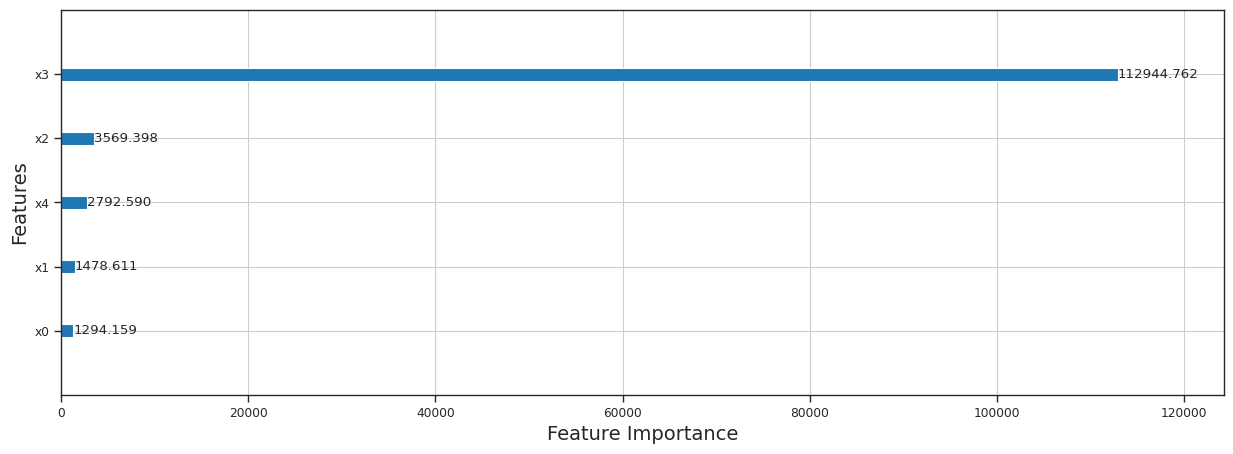

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

lgb.plot_importance(model, max_num_features=5, importance_type='gain', ax =ax)
ax.set_title("")
ax.set_xlabel(f"Feature Importance", fontsize=14)
ax.set_ylabel(f"Features", fontsize=14)
plt.savefig("FeatureImportance.png", format="png", dpi=300)
plt.show()


In [ ]:
asv_shape = asv_values.pivot(index="index", columns="feature", values="asv_value")
non_asv_shape = non_asv_values.pivot(index="index", columns="feature", values="asv_value")

asv_shape_test = asv_shape.loc[test.index]
non_asv_shape_test = non_asv_shape.loc[test.index]
test_data = test_x.loc[test.index]

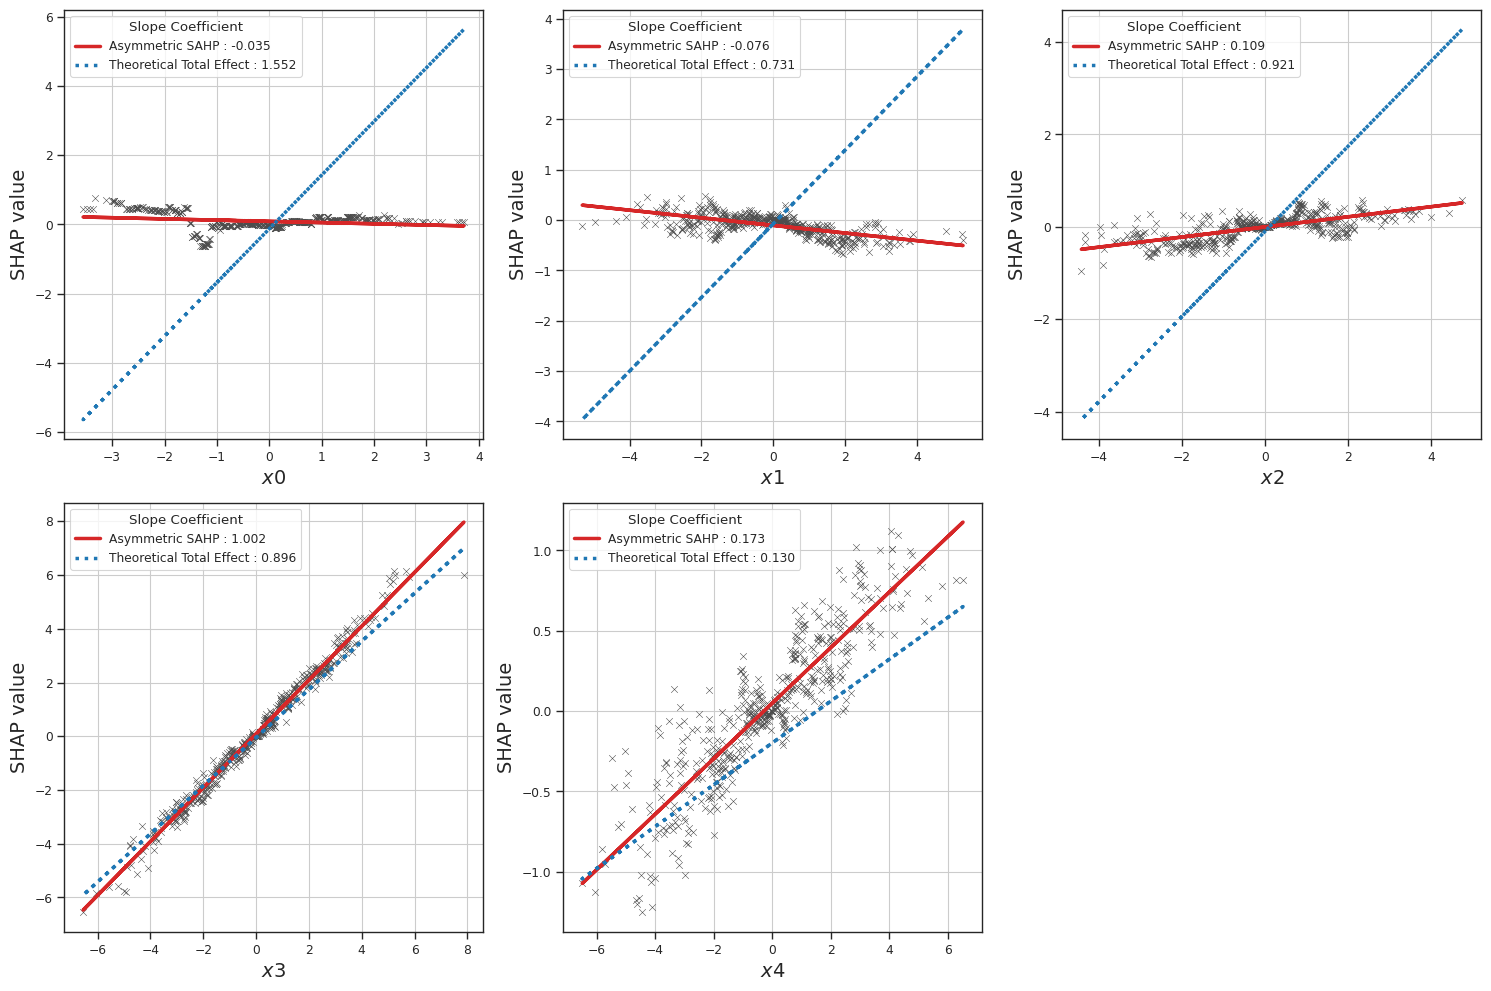

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)  # 2行3列のサブプロット
axes = axes.flat  # axesをフラット化して1次元のリストとして扱う

for i, _col in enumerate(test_x.columns):
    sns.scatterplot(
        x=test_data[_col],
        y=asv_shape_test[_col],
        marker="x", color=".3",
        ax=axes[i],
        label=""
    )

    coef = np.polyfit(test_data[_col], asv_shape_test[_col], 1)
    poly1d_fn = np.poly1d(coef)

    axes[i].plot(
        test_data[_col],
        poly1d_fn(test_data[_col]),
        'tab:red',
        lw=2.5,
        ls='-',
        label=f'Asymmetric SAHP : {coef[0]:.3f}'
    )

    axes[i].plot(
        test_data[_col],
        test_data[_col].mean() + test_data[_col] * ground_truth[_col],
        'tab:blue',
        lw=2.5,
        ls=':',
        label=f'Theoretical Total Effect : {ground_truth[_col]:.3f}'
    )

    axes[i].grid()
    axes[i].legend(title='Slope Coefficient', loc='upper left')
    axes[i].set_xlabel(f"${_col}$", fontsize=14)
    axes[i].set_ylabel(f"SHAP value", fontsize=14)

# プロットが6個未満の場合に余分なサブプロットを非表示にする
for j in range(len(test_x.columns), len(axes)):
    fig.delaxes(axes[j])

plt.savefig("asv_scatter_plot.png", format="png", dpi=300)
plt.show()


In [ ]:
# fig, axes = plt.subplots(1, 5, figsize=(20, 5), tight_layout=True)
# for i, _col in enumerate(test_x.columns):
#     sns.scatterplot(
#         x = test_data[_col],
#         y = asv_shape_test[_col],
#         marker="x", color=".3",
#         ax=axes[i],
#         label=""
#     )

#     coef = np.polyfit(test_data[_col],asv_shape_test[_col],1)
#     poly1d_fn = np.poly1d(coef)

#     axes[i].plot(
#         test_data[_col],
#         poly1d_fn(test_data[_col]),
#         'tab:red',
#         lw=2.5,
#         ls='-',
#         label=f'Asymmetric SAHP : {coef[0]:.3f}'
#         )


#     axes[i].plot(
#         test_data[_col],
#         test_data[_col].mean() + test_data[_col]*ground_truth[_col],
#         'tab:blue',
#         lw=2.5,
#         ls=':',
#         label=f'Theoretical Total Effect : {ground_truth[_col]:.3f}'
#         )

#     axes[i].grid()
#     axes[i].legend(title='Slope Coefficient', loc='upper left')
#     axes[i].set_xlabel(f"${_col}$")
#     axes[i].set_ylabel(f"SHAP value")
# plt.savefig("asv_scatter_plot.png", format="png", dpi=300)
# plt.show()

In [ ]:
# fig, axes = plt.subplots(1, 5, figsize=(20, 5), tight_layout=True)
# for i, _col in enumerate(test_x.columns):
#     sns.scatterplot(
#         x = test_data[_col],
#         y = asv_shape_test[_col],
#         marker="x", color=".3",
#         ax=axes[i],
#         label=""
#     )

#     coef = np.polyfit(test_data[_col],asv_shape_test[_col],1)
#     poly1d_fn = np.poly1d(coef)

#     axes[i].plot(
#         test_data[_col],
#         poly1d_fn(test_data[_col]),
#         'tab:red',
#         lw=2.5,
#         ls='-',
#         label=f'Asymmetric SAHP : {coef[0]:.3f}'
#         )

#     coef = np.polyfit(test_data[_col],non_asv_shape_test[_col],1)
#     poly1d_fn = np.poly1d(coef)

#     axes[i].plot(
#         test_data[_col],
#         poly1d_fn(test_data[_col]),
#         'tab:green',
#         lw=2.5,
#         ls=':',
#         label=f'Standerd SHAP : {coef[0]:.3f}'
#         )

#     axes[i].grid()
#     axes[i].legend(title='Slope Coefficient', loc='upper left')
#     axes[i].set_xlabel(f"${_col}$")
#     axes[i].set_ylabel(f"SHAP value")

# plt.show()

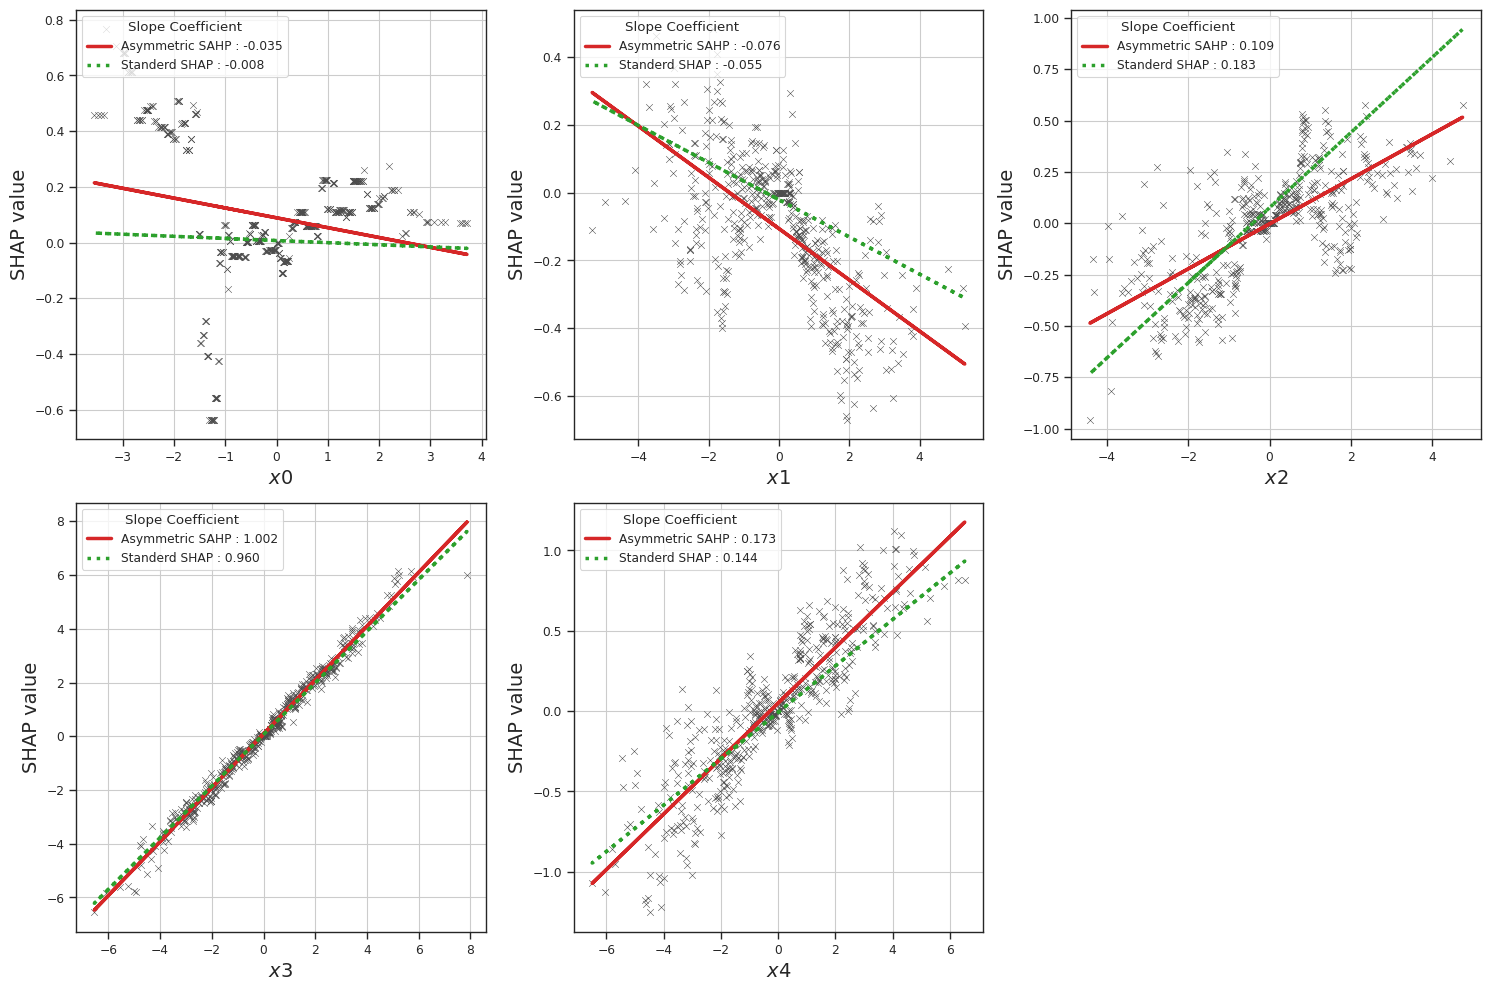

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)  # 2行3列のサブプロット
axes = axes.flat  # axesをフラット化して1次元のリストとして扱う
for i, _col in enumerate(test_x.columns):
    sns.scatterplot(
        x = test_data[_col],
        y = asv_shape_test[_col],
        marker="x", color=".3",
        ax=axes[i],
        label=""
    )

    coef = np.polyfit(test_data[_col],asv_shape_test[_col],1)
    poly1d_fn = np.poly1d(coef)

    axes[i].plot(
        test_data[_col],
        poly1d_fn(test_data[_col]),
        'tab:red',
        lw=2.5,
        ls='-',
        label=f'Asymmetric SAHP : {coef[0]:.3f}'
        )

    coef = np.polyfit(test_data[_col],non_asv_shape_test[_col],1)
    poly1d_fn = np.poly1d(coef)

    axes[i].plot(
        test_data[_col],
        poly1d_fn(test_data[_col]),
        'tab:green',
        lw=2.5,
        ls=':',
        label=f'Standerd SHAP : {coef[0]:.3f}'
        )

    axes[i].grid()
    axes[i].legend(title='Slope Coefficient', loc='upper left')
    axes[i].set_xlabel(f"${_col}$", fontsize=14)
    axes[i].set_ylabel(f"SHAP value", fontsize=14)

# プロットが6個未満の場合に余分なサブプロットを非表示にする
for j in range(len(test_x.columns), len(axes)):
    fig.delaxes(axes[j])
plt.savefig("asv_vs_shap.png", format="png", dpi=300)
plt.show()